In [1]:
#change working dir to current file location

import os
import time
os.chdir('C:\\Users\\wren1\\Documents\\theory of machine learning\\EN625.742_group_project\\src')
from Code.Utils import utils
from Code.Charts import charts
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
#import TargetEncoder
from sklearn.feature_selection import chi2, f_classif, SelectKBest

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Feature Engineering

Steps:

1. Read in data
2. Clean data
3. Encode features
4. Feature selection

In [2]:
## Read in data 
print(os.getcwd())
full_df = pd.read_csv('data/sbdb_query_results.csv')
full_df.info(verbose=True, show_counts=True)

C:\Users\wren1\Documents\theory of machine learning\EN625.742_group_project\src
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35188 entries, 0 to 35187
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       35188 non-null  object 
 1   a               35188 non-null  float64
 2   e               35188 non-null  float64
 3   i               35188 non-null  float64
 4   om              35188 non-null  float64
 5   w               35188 non-null  float64
 6   q               35188 non-null  float64
 7   ad              35188 non-null  float64
 8   per_y           35188 non-null  float64
 9   data_arc        34876 non-null  float64
 10  condition_code  35187 non-null  float64
 11  n_obs_used      35188 non-null  int64  
 12  n_del_obs_used  1030 non-null   float64
 13  n_dop_obs_used  1030 non-null   float64
 14  H               35183 non-null  float64
 15  epoch_mjd       35188 non-null  int64  
 

C:\Users\wren1\AppData\Local\Temp\ipykernel_25812\3398585979.py:3: DtypeWarning: Columns (18,25,26,29,61) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv('data/sbdb_query_results.csv')


In [3]:
# Clean data

# drop any colums with more than 20% missing values
df = utils.filterLowDataColumns(full_df, 0.2)

# drop any rows with missing values
df = df.dropna()

# df.info(verbose=True, show_counts=True)

# # drop any columns that are not useful for the model, like the producer of the record,
# the time of observation, and the standard error of existing columns
cols_to_drop = ['epoch_mjd', 
                'epoch', 
                'epoch_cal', 
                'first_obs', 
                'last_obs', 
                'producer',
                'sigma_e',
                'sigma_a',
                'sigma_q',
                'sigma_i',
                'sigma_om',
                'sigma_w',
                'sigma_ma',
                'sigma_ad',
                'sigma_n',
                'sigma_tp',
                'sigma_per',
                'rms',
                'full_name',
                'pdes',
                'condition_code',
                'tp_cal',
                'neo',
                'equinox',
                'sats']


df = df.drop(columns=cols_to_drop)

# drop spkid column - unique identifier
df = df.drop(columns=['spkid'])

# reset index to match the number of rows
df = df.reset_index(drop=True)

# separate target variable from features
target = df['pha']
features = df.drop(columns=['pha'])

#convert target from Y/N to 1/0

target = target.map({'Y': 1, 'N': 0})

# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Check for class imbalance
print(y_train.value_counts())

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# check if oversampling worked
print(y_train.value_counts())

# Scale numerical columns with RobustScaler (since many columns are not normally distributed)
num_cols = features.select_dtypes(include=['float64','int64']).columns

# Scale Numerical Columns with Robust Scaler
scaler = RobustScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Encode categorical variables
categorical_cols = features.select_dtypes(include=['object']).columns

# Fit and transform categorical columns
encoder = ce.cat_boost.CatBoostEncoder()

# create new columns for the encoded variables
encoded_col_names = [col + '_encoded' for col in categorical_cols]

X_train[encoded_col_names] = encoder.fit_transform(X_train[categorical_cols], y_train)
X_test[encoded_col_names] = encoder.transform(X_test[categorical_cols])

# check if transformations and encoding worked
print(X_train.info())
print(X_train.head())


pha
0    25898
1     1979
Name: count, dtype: int64
pha
0    25898
1    25898
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51796 entries, 0 to 51795
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   a                 51796 non-null  float64
 1   e                 51796 non-null  float64
 2   i                 51796 non-null  float64
 3   om                51796 non-null  float64
 4   w                 51796 non-null  float64
 5   q                 51796 non-null  float64
 6   ad                51796 non-null  float64
 7   per_y             51796 non-null  float64
 8   data_arc          51796 non-null  float64
 9   n_obs_used        51796 non-null  float64
 10  H                 51796 non-null  float64
 11  ma                51796 non-null  float64
 12  n                 51796 non-null  float64
 13  tp                51796 non-null  float64
 14  per               51796 non-nu

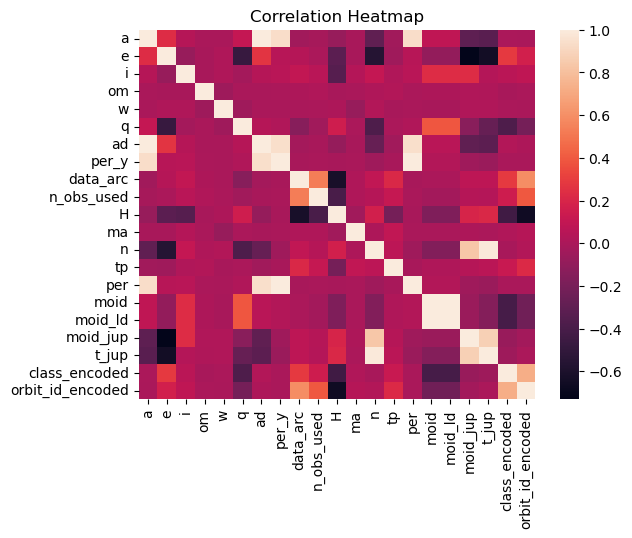

['ad', 'per', 'moid_ld', 't_jup']


In [4]:
# check for feature multicollinearity
# While tree methods are generally robust to multicollinearity, it is helpful to 
#  remove highly correlated features since they do not add any additional information
#  to the model and can impact feature importance scores
X_train_num = X_train.select_dtypes(include=['float64','int64'])

corr = X_train_num.corr()
sns.heatmap(corr, annot=False)
plt.title('Correlation Heatmap')
plt.show()

# drop highly correlated features
corr_matrix = X_train_num.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51796 entries, 0 to 51795
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   a                 51796 non-null  float64
 1   e                 51796 non-null  float64
 2   i                 51796 non-null  float64
 3   om                51796 non-null  float64
 4   w                 51796 non-null  float64
 5   q                 51796 non-null  float64
 6   per_y             51796 non-null  float64
 7   data_arc          51796 non-null  float64
 8   n_obs_used        51796 non-null  float64
 9   H                 51796 non-null  float64
 10  ma                51796 non-null  float64
 11  n                 51796 non-null  float64
 12  tp                51796 non-null  float64
 13  moid              51796 non-null  float64
 14  moid_jup          51796 non-null  float64
 15  class             51796 non-null  object 
 16  orbit_id          51796 non-null  object

In [6]:
# Fit xgboost model

xgbm = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

#remove non-numeric columns
X_train_num = X_train.select_dtypes(include=['float64','int64'])
X_test_num = X_test.select_dtypes(include=['float64','int64'])

#start time record
start_time = time.time()

grid_search = GridSearchCV(estimator=xgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_num, y_train)

#end time record
end_time = time.time()
print(f'XGBM Grid Search Time: {end_time - start_time}')

print(grid_search.best_params_)
print(grid_search.best_score_)
xgbm_best = grid_search.best_estimator_

# Evaluate best model
y_pred = xgbm_best.predict(X_test_num)
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBM Model Accuracy: {accuracy}')

## Save the model to disk as a pickle file
with open('xgbm_best_model.pkl', 'wb') as file:
    pickle.dump(xgbm_best, file)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBM Grid Search Time: 70.10619711875916
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.9943436032532471
XGBM Model Accuracy: 0.9796269727403156


In [7]:
# Fit lightgbm model

lgbm = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127]
}


#start time record
start_time = time.time()

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')
try:
    grid_search.fit(X_train_num, y_train)
except Exception as e:
    print('Error:', e)

#end time record
end_time = time.time()
print(f'LGBM Grid Search Time: {end_time - start_time}')

print(grid_search.best_params_)
print(grid_search.best_score_)
lgbm_best = grid_search.best_estimator_

# Evaluate best model
y_pred = lgbm_best.predict(X_test_num)
accuracy = accuracy_score(y_test, y_pred)
print(f'LGBM Model Accuracy: {accuracy}')

## Save the model to disk as a pickle file
with open('lgbm_best_model.pkl', 'wb') as file:
    pickle.dump(lgbm_best, file)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 25898, number of negative: 25898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 51796, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [8]:
#fit catboost model

catb = cb.CatBoostClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

#remove encoded columns
X_train_cat = X_train.drop(columns=encoded_col_names)
X_test_cat = X_test.drop(columns=encoded_col_names)

print(X_train_cat.info())
print(categorical_cols.tolist())

# Get the indices of the categorical columns
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
X_train[categorical_cols].head()

#start time record
start_time = time.time()

grid_search = GridSearchCV(estimator=catb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')
try:
    grid_search.fit(X_train_cat, y_train, cat_features=categorical_indices)
except Exception as e:
    print(e)
#end time record
end_time = time.time()
print(f'CatBoost Grid Search Time: {end_time - start_time}')

print(grid_search.best_params_)
print(grid_search.best_score_)
catb_best = grid_search.best_estimator_

# Evaluate best model
y_pred = catb_best.predict(X_test_cat)
accuracy = accuracy_score(y_test, y_pred)
print(f'CatBoost Model Accuracy: {accuracy}')

## Save the model to disk as a pickle file
with open('catb_best_model.pkl', 'wb') as file:
    pickle.dump(catb_best, file)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51796 entries, 0 to 51795
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   a           51796 non-null  float64
 1   e           51796 non-null  float64
 2   i           51796 non-null  float64
 3   om          51796 non-null  float64
 4   w           51796 non-null  float64
 5   q           51796 non-null  float64
 6   per_y       51796 non-null  float64
 7   data_arc    51796 non-null  float64
 8   n_obs_used  51796 non-null  float64
 9   H           51796 non-null  float64
 10  ma          51796 non-null  float64
 11  n           51796 non-null  float64
 12  tp          51796 non-null  float64
 13  moid        51796 non-null  float64
 14  moid_jup    51796 non-null  float64
 15  class       51796 non-null  object 
 16  orbit_id    51796 non-null  object 
dtypes: float64(15), object(2)
memory usage: 6.7+ MB
None
['class', 'orbit_id']
Fitting 5 folds for each of 27 c

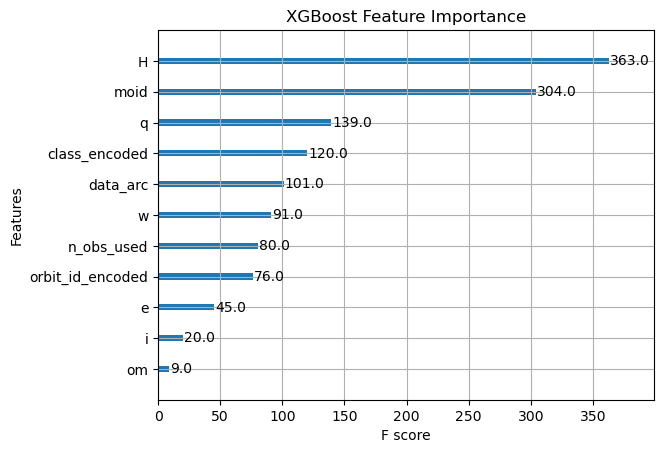

[LightGBM] [Info] Number of positive: 25898, number of negative: 25898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 51796, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

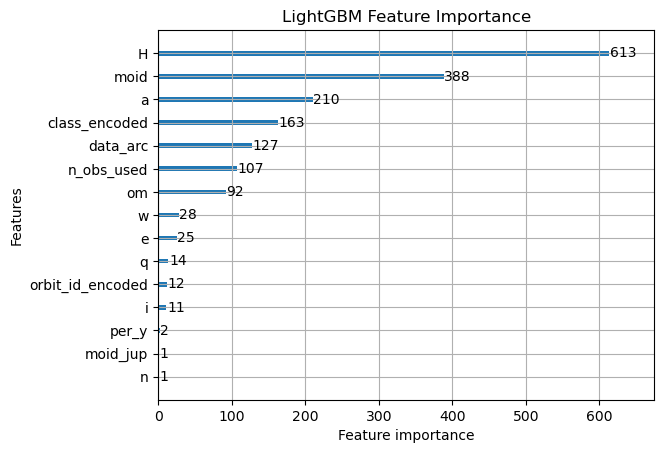

0:	learn: 0.4547669	total: 74.6ms	remaining: 14.8s
1:	learn: 0.2780712	total: 140ms	remaining: 13.9s
2:	learn: 0.1856508	total: 210ms	remaining: 13.8s
3:	learn: 0.1300361	total: 279ms	remaining: 13.7s
4:	learn: 0.0858949	total: 348ms	remaining: 13.6s
5:	learn: 0.0627653	total: 427ms	remaining: 13.8s
6:	learn: 0.0466810	total: 499ms	remaining: 13.8s
7:	learn: 0.0310453	total: 577ms	remaining: 13.8s
8:	learn: 0.0242182	total: 650ms	remaining: 13.8s
9:	learn: 0.0201773	total: 726ms	remaining: 13.8s
10:	learn: 0.0163945	total: 806ms	remaining: 13.9s
11:	learn: 0.0142757	total: 882ms	remaining: 13.8s
12:	learn: 0.0126351	total: 956ms	remaining: 13.8s
13:	learn: 0.0108007	total: 1.03s	remaining: 13.7s
14:	learn: 0.0098774	total: 1.11s	remaining: 13.7s
15:	learn: 0.0090317	total: 1.19s	remaining: 13.7s
16:	learn: 0.0079557	total: 1.34s	remaining: 14.4s
17:	learn: 0.0076188	total: 1.42s	remaining: 14.3s
18:	learn: 0.0075360	total: 1.5s	remaining: 14.3s
19:	learn: 0.0067755	total: 1.58s	remaini

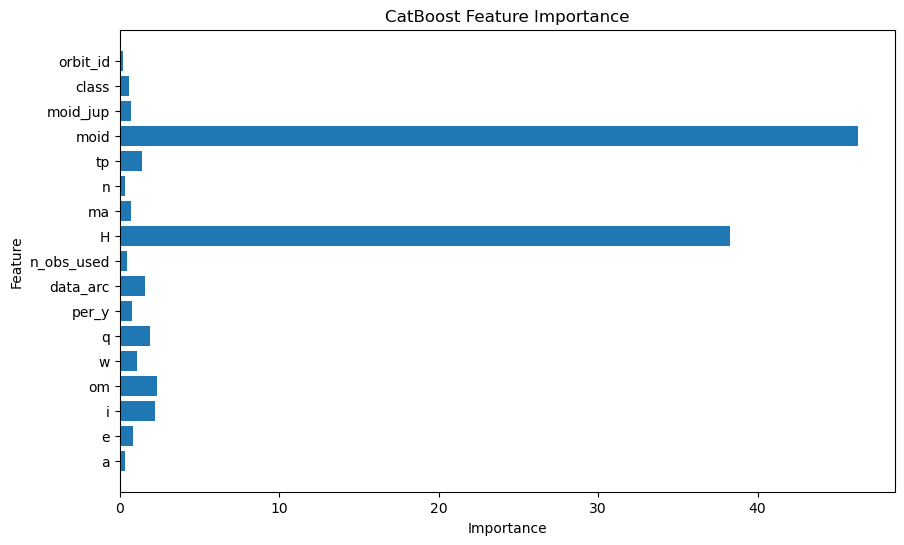

In [9]:
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Feature Importance for each model

# XGBoost
xgbm_best.fit(X_train_num, y_train)
xgb.plot_importance(xgbm_best)
plt.title('XGBoost Feature Importance')
plt.show()

# LightGBM
lgbm_best.fit(X_train_num, y_train)
lgb.plot_importance(lgbm_best)
plt.title('LightGBM Feature Importance')
plt.show()



# CatBoost

catb_best.fit(X_train_cat, y_train, cat_features=categorical_indices)
feature_importances = catb_best.get_feature_importance(Pool(X_train_cat, label=y_train, cat_features=categorical_indices))
feature_names = X_train_cat.columns

# Plot CatBoost feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

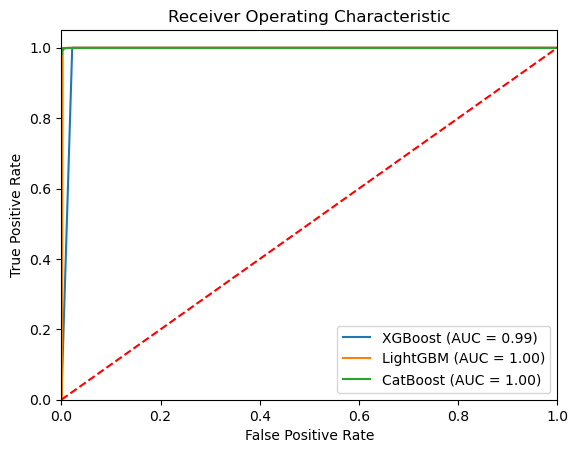

In [10]:
#AUC ROCE Curve for all three models on test data

# XGBoost
y_pred = xgbm_best.predict_proba(X_test_num)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc)

# LightGBM
y_pred = lgbm_best.predict_proba(X_test_num)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='LightGBM (AUC = %0.2f)' % roc_auc)

# CatBoost
y_pred = catb_best.predict_proba(X_test_cat)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CatBoost (AUC = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



XGBoost F1 Score: 0.8660377358490566
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6511
           1       0.76      1.00      0.87       459

    accuracy                           0.98      6970
   macro avg       0.88      0.99      0.93      6970
weighted avg       0.98      0.98      0.98      6970

[[6369  142]
 [   0  459]]
LightGBM F1 Score: 0.8852459016393442
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6511
           1       0.79      1.00      0.89       459

    accuracy                           0.98      6970
   macro avg       0.90      0.99      0.94      6970
weighted avg       0.99      0.98      0.98      6970

[[6392  119]
 [   0  459]]
CatBoost F1 Score: 0.9859154929577465
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6511
           1       0.98      0.99      0.99       459

    accuracy   

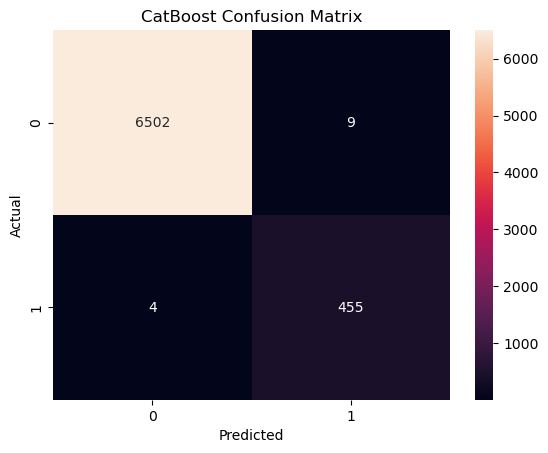

CatBoost Mean Squared Error: 0.0018651362984218078


In [15]:
#get the F1 score, precision, recall, f1 score, and mse for each model

# XGBoost
y_pred = xgbm_best.predict(X_test_num)
f1 = f1_score(y_test, y_pred)
print(f'XGBoost F1 Score: {f1}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# LightGBM
y_pred = lgbm_best.predict(X_test_num)
f1 = f1_score(y_test, y_pred)
print(f'LightGBM F1 Score: {f1}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# CatBoost
y_pred = catb_best.predict(X_test_cat)
f1 = f1_score(y_test, y_pred)
print(f'CatBoost F1 Score: {f1}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#print actual accuracy for catboost

accuracy = accuracy_score(y_test, y_pred)
print(f'CatBoost Model Accuracy: {accuracy}')

#plot confusion matrix for catboost

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost Confusion Matrix')
plt.show()

#print mse for catboost

mse = np.mean((y_test - y_pred)**2)

print(f'CatBoost Mean Squared Error: {mse}')